In [2]:
import torch
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, TensorDataset
import wandb

### 4.1 Data Visualisation and Preprocessing ###

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

batch_size = 60000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x = None
y = None
for images, labels in train_loader:
    x = images
    y = labels

[]

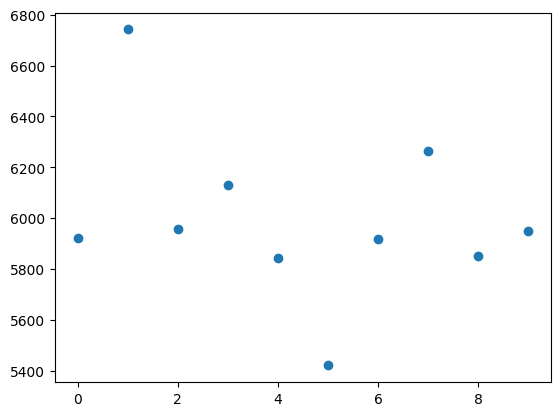

In [4]:
labels, count = torch.unique(y, return_counts=True)
plt.scatter(labels, count)
plt.plot()

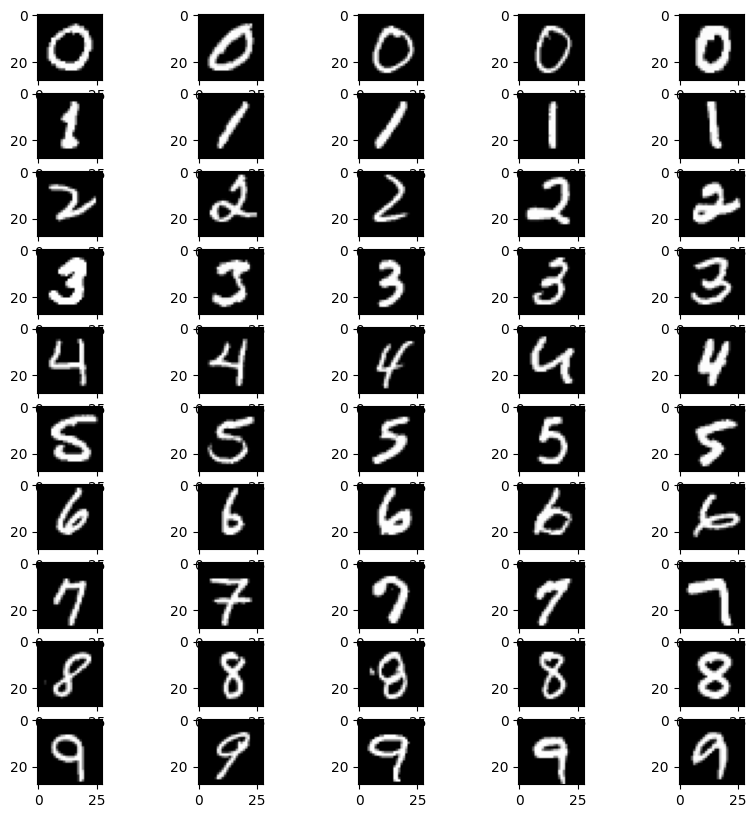

In [5]:
class_images = [5]*10
image_display = {}

for images, labels in zip(x, y):
    label = labels.item()
    if label not in image_display:
        image_display[label] = []
    if (class_images[label] > 0):
        if len(images.shape) == 3 and images.shape[0] == 1:
            images = images[0, :, :]
        image_display[label].append(images)
        class_images[label] -= 1
    if all(count <= 0 for count in class_images):
        break


fig, axes = plt.subplots(10, 5, figsize=(10, 10))
for i in range(10):
    for j in range(5):
        axes[i, j].imshow(image_display[i][j], cmap='gray')
        axes[i, j].axis('on')
plt.show()

### Observation of Class Imbalance ###

We observe that there exist a larger number of images of the digit 1 and a smaller number of images of digit 5 as compared to other digits. Number of Images of all other digits are more or less the same (as expected).

In [ ]:
def visualize_feature_maps(model, image, target_layer, num_feature_maps):
    model.eval()
    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output.data
    target_layer.register_forward_hook(hook)
    with torch.no_grad():
        model(image)
    target_layer.unregister_forward_hook(hook)
    fig, axarr = plt.subplots(1, num_feature_maps, figsize=(20, 5))
    for i in range(num_feature_maps):
        axarr[i].imshow(feature_maps[0, i].cpu(), cmap='viridis')
        axarr[i].axis('off')
        axarr[i].set_title(f"Feature Map {i+1}")
    
    plt.show()

In [6]:
train_size = int(0.7 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

### 4.2 Model Building ###

In [6]:
class CNN(nn.Module):
    def __init__(self, output_shape, p):
        super().__init__()

        # Architecture 1
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 7 * 7, output_shape)
        self.dropout = nn.Dropout(p)

        # Architecture 2
        self.conv1_2 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc_2 = nn.Linear(32 * 7 * 7, output_shape)

    

    def activate(self, x):
        return nn.functional.softmax(x)


    def forward(self, x, choice, architecture):                   # choice = 1 means dropout is employed, else not

        if (architecture == 1):
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            x = x.view(-1, 64 * 7 * 7)
            if (choice == 1):
                x = self.dropout(x)
            x = self.fc(x)
            return x
        else:
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            if (choice == 1):
                x = self.dropout(x)
            x = self.fc(x)
            return x


In [8]:
def train_cnn(p, batch_size, lr, epochs, choice, architecture):
    cnn = CNN(10, p = p)                  # 10 unique classes in MNIST Dataset
    optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_pred = 0
        train_total = 0
        cnn.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = cnn(inputs, choice, architecture)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            correct_pred += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_pred / train_total
        avg_train_loss = running_loss / len(train_loader)

        val_loss = 0.0
        correct_pred = 0
        val_total = 0
        cnn.eval()

        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = cnn(inputs, choice, architecture)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                correct_pred += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_pred / val_total
        avg_val_loss = running_loss / len(train_loader)
        print("Epoch = ", epoch)
        print("Training Loss: ", avg_train_loss, "Training Accuracy: ", train_accuracy, "%")
        print("Validation Loss: ", avg_val_loss, "Validation Accuracy: ", val_accuracy, "%")
    
    return val_accuracy 

In [10]:
train_cnn(0.5, 32, 0.001, 10, 1, 1)

Epoch =  0
Training Loss:  0.20026174314360518 Training Accuracy:  93.89761904761905 %
Validation Loss:  0.20026174314360518 Validation Accuracy:  98.01666666666667 %
Epoch =  1
Training Loss:  0.08211735084933787 Training Accuracy:  97.45238095238095 %
Validation Loss:  0.08211735084933787 Validation Accuracy:  98.56666666666666 %
Epoch =  2
Training Loss:  0.06469145951620059 Training Accuracy:  97.96190476190476 %
Validation Loss:  0.06469145951620059 Validation Accuracy:  98.40833333333333 %
Epoch =  3
Training Loss:  0.05825578696597176 Training Accuracy:  98.13571428571429 %
Validation Loss:  0.05825578696597176 Validation Accuracy:  98.65833333333333 %
Epoch =  4
Training Loss:  0.05198499224456265 Training Accuracy:  98.41190476190476 %
Validation Loss:  0.05198499224456265 Validation Accuracy:  98.89166666666667 %
Epoch =  5
Training Loss:  0.04694045541858946 Training Accuracy:  98.46190476190476 %
Validation Loss:  0.04694045541858946 Validation Accuracy:  98.86666666666666 

98.975

### 4.3 Hyperparameter Tuning ###

In [8]:
wandb.init(
    project="Q4 Assignment 3",
    config={
        "optimizer": "gd",
        "loss": "crossentropy",
        "metric": "accuracy",
        "epoch": 1000
    }
)

# Access the configuration that you have set
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: pranav-g (pranavg1). Use `wandb login --relogin` to force relogin


In [53]:
lr = [0.001, 0.01]
epochs = [2, 3, 5]
batch_size = [32, 64]
dropout_rates = [0.2, 0.5]
architectures = [1, 2]

val_acc = []
for learning_rate in lr:
    for batch in batch_size:
        for dropout in dropout_rates:
            print("Learning Rate = ", learning_rate, "Batch Size = ", batch, "Dropout Rate = ", dropout)
            a = train_cnn(dropout, batch, learning_rate, 2, 1, 1)
            val_acc.append([a, learning_rate, batch, dropout])
            wandb.log({"Learning Rate: ": learning_rate, "Batch: ": batch, "Dropout: ": dropout, "Accuracy: ": a})
val_acc.sort()

val_acc1 = []
for epoch in epochs:
    for architecture in architectures:
        print("Number of Epochs = ", epoch, "Architecture Used = ", architecture)
        a = train_cnn(val_acc[0][3], 32, val_acc[0][1], epoch, 1, architecture)
        val_acc1.append([a, epoch, 1, architecture])
        wandb.log({"Epoch: ": epoch, "Choice: ": 1, "Architecture: ": architecture, "Accuracy: ": a})
val_acc1.sort()

# to compare dropout's presence/absence 
a = train_cnn(val_acc[len(val_acc)-1][3], val_acc[len(val_acc)-1][2], val_acc[len(val_acc)-1][1], epoch, 0, architecture)    

Learning Rate =  0.001 Batch Size =  32 Dropout Rate =  0.2
Epoch =  0
Training Loss:  0.16480645733464847 Training Accuracy:  95.0547619047619 %
Validation Loss:  0.16480645733464847 Validation Accuracy:  98.08333333333333 %
Epoch =  1
Training Loss:  0.059107175383252934 Training Accuracy:  98.20476190476191 %
Validation Loss:  0.059107175383252934 Validation Accuracy:  98.33333333333333 %
Learning Rate =  0.001 Batch Size =  32 Dropout Rate =  0.5
Epoch =  0
Training Loss:  0.1937668413240874 Training Accuracy:  94.1047619047619 %
Validation Loss:  0.1937668413240874 Validation Accuracy:  98.10833333333333 %
Epoch =  1
Training Loss:  0.08113830439366546 Training Accuracy:  97.51904761904763 %
Validation Loss:  0.08113830439366546 Validation Accuracy:  98.64166666666667 %
Learning Rate =  0.001 Batch Size =  64 Dropout Rate =  0.2
Epoch =  0
Training Loss:  0.20326564764912997 Training Accuracy:  93.99047619047619 %
Validation Loss:  0.20326564764912997 Validation Accuracy:  97.7 %


In [61]:
# val_acc1.append([a, epoch, 0, architecture])
# val_acc1.sort()
print("Best Model in terms of accuracy is learning rate = ", val_acc[0][1], "Batch size = ", val_acc[0][2], "Dropout rates = ", val_acc[0][3], "Epochs = ", val_acc1[0][1], "Dropout use or not(T/F) = ", val_acc1[0][2], "Architecture = ", val_acc1[0][3])

print(val_acc)
cnn = CNN(10, p = val_acc[len(val_acc)-1][3])
optimizer = torch.optim.Adam(cnn.parameters(), lr=val_acc[len(val_acc)-1][1])
criterion = nn.CrossEntropyLoss()
test_loader = DataLoader(test_dataset, batch_size=val_acc[len(val_acc)-1][2], shuffle=False)
val_loss = 0.0
running_loss = 0.0
correct_pred = 0
val_total = 0
cnn.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = cnn(inputs, val_acc1[len(val_acc1)-1][2], val_acc1[len(val_acc1)-1][3])
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
val_accuracy = 100 * correct_pred / val_total
avg_val_loss = val_loss / len(test_loader)
print("Epoch = ", epoch)
print("Test Loss: ", avg_val_loss, "Validation Accuracy: ", val_accuracy, "%")

Best Model in terms of accuracy is learning rate =  0.01 Batch size =  32 Dropout rates =  0.2 Epochs =  3 Dropout use or not(T/F) =  1 Architecture =  1
[[96.60833333333333, 0.01, 32, 0.2], [96.81666666666666, 0.01, 32, 0.5], [97.19166666666666, 0.01, 64, 0.2], [97.94166666666666, 0.01, 64, 0.5], [98.33333333333333, 0.001, 32, 0.2], [98.34166666666667, 0.001, 64, 0.5], [98.43333333333334, 0.001, 64, 0.2], [98.64166666666667, 0.001, 32, 0.5]]
Epoch =  5
Test Loss:  2.307126593082509 Validation Accuracy:  11.633333333333333 %


Using Dropout or not creates a lot of impact in scenarios like these, when accuracies obtained on validation set are almost similar. In such cases, it becomes difficult to distinguish between different set of hyperparameters. One solution is to simply select the best performing set of hyperparameters on the Validation set. Another solution is to try all the models and check the model with the highest accuracies on test set. Here, although the first solution is implemented.  

### 4.5 Training Noisy MNIST ###

In [7]:
import scipy.io
mat = scipy.io.loadmat('./mnist-with-awgn.mat')
train_x = mat['train_x']
test_x = mat['test_x']
train_y = mat['train_y']
test_y = mat['test_y']
x_train = torch.from_numpy(train_x).view(-1, 1, 28, 28).float()
x_test = torch.from_numpy(test_x).view(-1, 1, 28, 28).float()
y_train = torch.from_numpy(train_y).float()
y_test = torch.from_numpy(test_y).float()


# Defining an Object of Instance CNN Architecture Class 

cnn = CNN(10, p = 0.2)                  # 10 unique classes in MNIST Dataset
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
epochs = 10
criterion = nn.CrossEntropyLoss()


# Defining Custom Dataset
train_dataset = TensorDataset(x_train, y_train)
test_data_temp = TensorDataset(x_test, y_test)
val_size = int(0.33 * len(test_data_temp))
test_size = len(test_data_temp) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(test_data_temp, [val_size, test_size])


# Defining Data Loaders for Training, validation and Testing Datasets.
batch_size = 32
shuffle = True
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


for epoch in range(epochs):
    running_loss = 0.0
    correct_pred = 0
    train_total = 0
    cnn.train()

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn(inputs, 1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        correct_pred += (labels[torch.arange(labels.size(0)), predicted] == 1).sum().item()

    train_accuracy = 100 * correct_pred / train_total
    avg_train_loss = running_loss / len(train_loader)

    val_loss = 0.0
    correct_pred = 0
    val_total = 0
    cnn.eval()

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = cnn(inputs, 1, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            correct_pred += (labels[torch.arange(labels.size(0)), predicted] == 1).sum().item()

    val_accuracy = 100 * correct_pred / val_total
    avg_val_loss = val_loss / len(train_loader)
    print("Epoch = ", epoch)
    print("Training Loss: ", avg_train_loss, "Training Accuracy: ", train_accuracy, "%")
    print("Validation Loss: ", avg_val_loss, "Validation Accuracy: ", val_accuracy, "%")


test_loss = 0.0
correct_pred = 0
test_total = 0
cnn.eval()

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        outputs = cnn(inputs, 1, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        correct_pred += (labels[torch.arange(labels.size(0)), predicted] == 1).sum().item()
test_accuracy = 100 * correct_pred / test_total
avg_test_loss = test_loss / len(test_loader)
print("Epoch = ", epoch)
print("Validation Loss: ", avg_test_loss, "Validation Accuracy: ", test_accuracy, "%")

Epoch =  0
Training Loss:  2.769459751001994 Training Accuracy:  10.925 %
Validation Loss:  0.12772367299397785 Validation Accuracy:  11.303030303030303 %
Epoch =  1
Training Loss:  2.302488640594482 Training Accuracy:  10.851666666666667 %
Validation Loss:  0.1277244649251302 Validation Accuracy:  11.303030303030303 %
Epoch =  2
Training Loss:  2.302492478942871 Training Accuracy:  10.85 %
Validation Loss:  0.12772458775838216 Validation Accuracy:  11.303030303030303 %
Epoch =  3
Training Loss:  2.3024930147806804 Training Accuracy:  10.85 %
Validation Loss:  0.12772459411621093 Validation Accuracy:  11.303030303030303 %
Epoch =  4
Training Loss:  2.302493087387085 Training Accuracy:  10.85 %
Validation Loss:  0.127724591700236 Validation Accuracy:  11.303030303030303 %
Epoch =  5
Training Loss:  2.302493105316162 Training Accuracy:  10.85 %
Validation Loss:  0.12772458585103352 Validation Accuracy:  11.303030303030303 %
Epoch =  6
Training Loss:  2.3024931090037026 Training Accuracy:

### 4.6 Denoising Auto Encoders Implementation and Training ###

In [196]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_temp_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_temp_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



model = autoencoders()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(10):
    for data in train_temp_loader:
        img, labels = data
        img = img.view(img.size(0), -1)
        noisy_img = img + 0.1 * torch.randn_like(img)
        optimizer.zero_grad()
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
    print("Epoch = ", epoch+1, "Loss = ", loss.item())

Epoch =  1 Loss =  0.045896679162979126
Epoch =  2 Loss =  0.03582409769296646
Epoch =  3 Loss =  0.035335980355739594
Epoch =  4 Loss =  0.03429793938994408
Epoch =  5 Loss =  0.034360259771347046
Epoch =  6 Loss =  0.036348115652799606
Epoch =  7 Loss =  0.04526469483971596
Epoch =  8 Loss =  0.03752174228429794
Epoch =  9 Loss =  0.041354548186063766
Epoch =  10 Loss =  0.03307028114795685


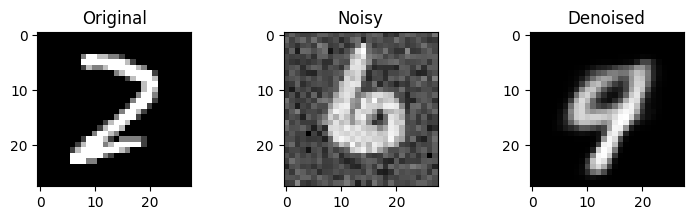

In [202]:
with torch.no_grad():
    model.eval()

    for data in test_temp_loader:
        img, labels = data
        img = img.view(img.size(0), -1)
        noisy_img = img + 0.15 * torch.randn_like(img)
        outputs = model(noisy_img)

        plt.figure(figsize=(9, 2))

        for i in range(1, 4):
            plt.subplot(1, 3, i)
            if i == 1:
                plt.title('Original')
                plt.imshow(np.reshape(img[i], (28, 28)), cmap='gray')
            elif i == 2:
                plt.title('Noisy')
                plt.imshow(np.reshape(noisy_img[i], (28, 28)), cmap='gray')
            else:
                plt.title('Denoised')
                plt.imshow(np.reshape(outputs[i], (28, 28)), cmap='gray')
        plt.show()
        break

#### 4.6 Data Visualisation ####

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


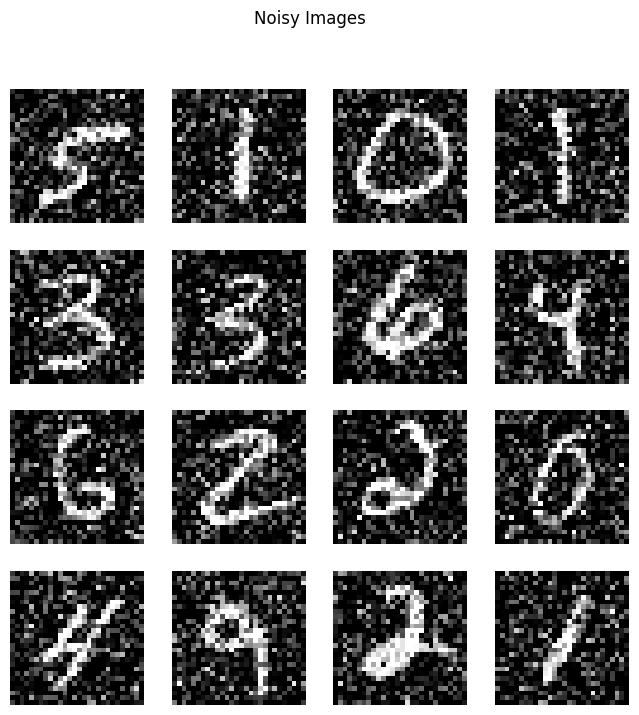

In [198]:
def visualize_data(images, title):
    print(images.shape)
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


train_dataset = TensorDataset(x_train, y_train)
test_data_temp = TensorDataset(x_test, y_test)
val_size = int(0.33 * len(test_data_temp))
test_size = len(test_data_temp) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(test_data_temp, [val_size, test_size])


# Defining Data Loaders for Training, validation and Testing Datasets.
batch_size = 64
shuffle = True
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


for data in test_loader:
    print(data[0].shape)
    visualize_data(data[0], "Noisy Images")
    break

In [229]:
# model = autoencoders()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
outputs = []

labels_ = np.zeros((6700, 10))
i = 0
with torch.no_grad():
    model.eval()

    for data in test_loader:
        img, labels = data
        count += labels.shape[0]
        noisy_img = img.view(img.size(0), -1)
        output = model(noisy_img)
        outputs.append(output)
        labels_[i:i+labels.shape[0]] = labels.numpy()  # Store the labels in labels_
        i += labels.shape[0]

(64, 1, 28, 28)


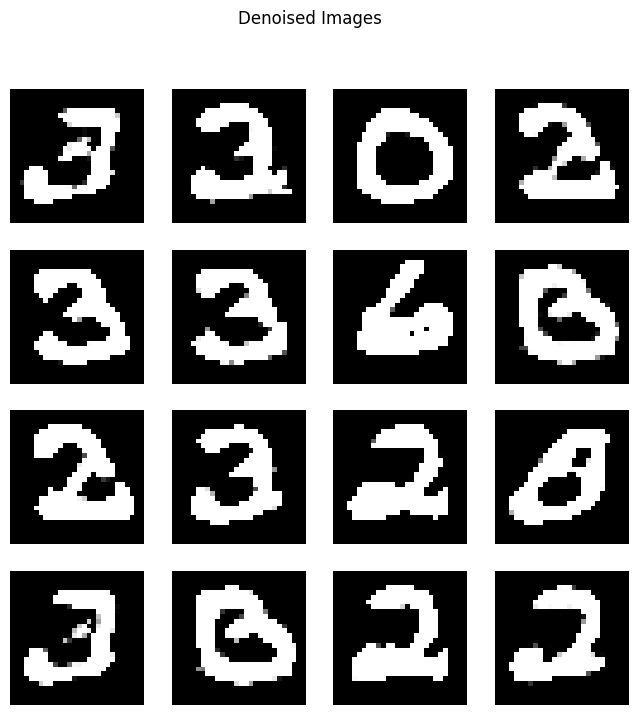

In [230]:
x = torch.reshape(outputs[0], (64, 1, 28, 28))
image = x.detach().numpy()
visualize_data(image, "Denoised Images")

In [239]:
test_loss = 0.0
correct_pred = 0
test_total = 0
cnn.eval()

i = 0
with torch.no_grad():
    for output in outputs:
        inputs = torch.reshape(output, (output.shape[0], 1, 28, 28))
        temp = cnn(inputs, 1, 1)
        _, predicted = torch.max(temp.data, 1)
        test_total += labels.size(0)
        for j in range(output.shape[0]):
            if labels_[i + j, predicted[j]] == 1:
                correct_pred += 1
        i += output.shape[0]
test_accuracy = 100 * correct_pred / test_total
print("Validation Accuracy: ", test_accuracy, "%")

Validation Accuracy:  12.554112554112555 %
